# UD-MIS of Gotham City Cell Towers via QAOA

#### Introduction

The quantum annealing approach is described by the theorem of quantum adiabatic evolution [1]. Application of this evolution in the realm of gate-model computing is through the discretization of the adiabatic continuous time evolution. <br>

The adiabatic computation states, that starting at time $t=0$, the system slowly evolves from the ground state in $H_{0}$ to the ground state in $H_{f}$, where $H_{0}$ is the initial Hamiltonian and $H_{f}$ is the final Hamiltonian defined by the minimization function of interest (i.e. - UD-MIS). This continuous evolution is approximated in gate-model architecture through a finite sequence of Hamiltonians, {$H_{j}$}, where<br>

$H_{j} = H(\frac{iT}{r}) = (1 - \frac{i}{r})H_{0} + \frac{i}{r}H_{f}$,

$\frac{T}{r}$ is the time duration per step, $r$ is the size of the set {$H_{j}$} and $T$ is the total time. Each $H_{j}$ is approximated by two unitary operators, as approximated by Campbell-Baker-Hausdorff theorem [2]. Hence, we deduce the unitary (per $j$): <br>

$U_{j} = e^{-i\frac{T}{r}(1-\frac{i}{r})H_{0}}e^{-i\frac{T}{r}(\frac{i}{r})H_{f}}$

The above unitary translates into the discrete adiabatic time-evolution of Quantum Approximate Optimization Algorithm (QAOA), which we examine below with PennyLane's QAOA package. <br>

Given the approximation of the adiabatic evolution explored by Quantum Annealing, the above discretization of the adiabatic evolution (as done through QAOA) is bounded by $O(n^{d+1}T^{2}/r)$ [3], where $n$ is the bit-string size. Thus, QAOA is not expected to perform as well as Quantum Annealing; yet, exploring QAOA allows us to examine the improvements required for NISQ gate-model based variational quantum algorithms.

#### Infrastructure

**Software**: PennyLane <br>
**Hardware**: PennyLane's qubit-based state simulator

In [204]:
import pennylane as qml
# from pennylane import numpy as np
import numpy as np
from pennylane import qaoa

import networkx as nx
import matplotlib.pyplot as plt

Helper function: for Graph construction

In [205]:
def find_edges(points):
    #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
    n = len(points)
    edges = np.zeros((n, n), dtype=bool)

    for i in range(n-1):
        x_i, y_i = points[i] # these are the x, y coordinates of the i'th vertex in the graph
        for j in range(i+1, n):
            x_j, y_j = points[j] # these are the x, y coordinates of the j'th vertex in the graph

            # calculate the distance between vertices
            dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
            if dij <= 1.0:
                edges[i,j] = True
                edges[j,i] = True

    return edges

**Problem** - As provided in Task 3 (Gotham City cell phone towers)

In [207]:
problem_points = [(1.19, 4.25), (2.71, 3.48), (1.19, 3.51), 
                   (2, 3.38), (1.12, 2.86), (1.70, 2.42), 
                   (2.36, 2.54), (1.52, 1.48), (2.15, 1.54), 
                   (2.14, 1.87), (1.72, 0.86), (2.29, 0.87)]

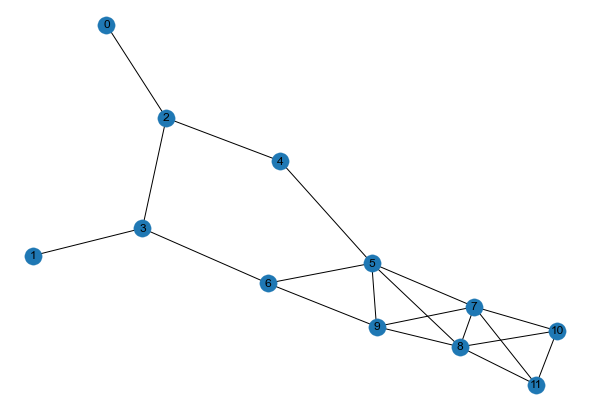

In [208]:
edges = find_edges(problem_points)

nx_graph = nx.from_numpy_array(edges)
nx.draw(nx_graph, with_labels=True)
plt.show()

**Cost and Mixer**

In [209]:
cost_h, mixer_h = qaoa.max_independent_set(nx_graph, constrained=True)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (1) [Z0]
+ (1) [Z1]
+ (1) [Z2]
+ (1) [Z3]
+ (1) [Z4]
+ (1) [Z5]
+ (1) [Z6]
+ (1) [Z7]
+ (1) [Z8]
+ (1) [Z9]
+ (1) [Z10]
+ (1) [Z11]
Mixer Hamiltonian   (0.03125) [X5]
+ (0.03125) [X7]
+ (0.03125) [X8]
+ (0.0625) [X9]
+ (0.125) [X2]
+ (0.125) [X3]
+ (0.125) [X6]
+ (0.125) [X10]
+ (0.125) [X11]
+ (0.25) [X4]
+ (0.5) [X0]
+ (0.5) [X1]
+ (0.03125) [X5 Z9]
+ (0.03125) [X5 Z8]
+ (0.03125) [X5 Z7]
+ (0.03125) [X5 Z6]
+ (0.03125) [X5 Z4]
+ (0.03125) [X7 Z11]
+ (0.03125) [X7 Z10]
+ (0.03125) [X7 Z9]
+ (0.03125) [X7 Z8]
+ (0.03125) [X7 Z5]
+ (0.03125) [X8 Z11]
+ (0.03125) [X8 Z10]
+ (0.03125) [X8 Z9]
+ (0.03125) [X8 Z7]
+ (0.03125) [X8 Z5]
+ (0.0625) [X9 Z8]
+ (0.0625) [X9 Z7]
+ (0.0625) [X9 Z6]
+ (0.0625) [X9 Z5]
+ (0.125) [X2 Z4]
+ (0.125) [X2 Z3]
+ (0.125) [X2 Z0]
+ (0.125) [X3 Z6]
+ (0.125) [X3 Z2]
+ (0.125) [X3 Z1]
+ (0.125) [X6 Z9]
+ (0.125) [X6 Z5]
+ (0.125) [X6 Z3]
+ (0.125) [X10 Z11]
+ (0.125) [X10 Z8]
+ (0.125) [X10 Z7]
+ (0.125) [X11 Z10]
+ (0.125) [X11 Z8]
+ (0.125

**QAOA construction**

In [210]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

**SGD Optimization, QAOA depth = 1**

In [227]:
wires = range(len(problem_points))
depth = 1

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, *params)

In [228]:
dev = qml.device("default.qubit", wires=wires)
cost_function_1 = qml.ExpvalCost(circuit, cost_h, dev)

In [229]:
gd_cost_depth_1 = []
params_1 = [[0.5], [0.5]]

for i in range(steps):
    params_1 = optimizer.step(cost_function_1, params_1)
    gd_cost_depth_1.append(cost_function_1(params_1))

print("Optimal Parameters")
print(params_1)

Optimal Parameters
[[0.7748610719873362], [-0.6146270451691794]]


**SGD Optimization, QAOA depth = 2**

In [240]:
wires = range(len(problem_points))
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, *params)

In [241]:
dev = qml.device("default.qubit", wires=wires)
cost_function_2 = qml.ExpvalCost(circuit, cost_h, dev)

In [217]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
# params = np.random.uniform(0, 2 * np.pi, (2, depth))
params_2 = [[0.5, 0.5], [0.5, 0.5]]
params_2

[[0.5, 0.5], [0.5, 0.5]]

In [214]:
gd_cost_depth_2 = []

for i in range(steps):
    params_2 = optimizer.step(cost_function_2, params_2)
    gd_cost_depth_2.append(cost_function_2(params_2))

print("Optimal Parameters")
print(params_2)

Optimal Parameters
[[1.0450288919785924, 0.6836931251447108], [0.7475837660583013, 1.3125255351741438]]


In [238]:
params_2 = [[1.0450288919785924, 0.6836931251447108], [0.7475837660583013, 1.3125255351741438]]

**SGD Optimization, QAOA depth = 3**

In [215]:
depth = 3
dev = qml.device("default.qubit", wires=wires)
cost_function_3 = qml.ExpvalCost(circuit, cost_h, dev)

In [219]:
gd_cost_depth_3 = []
params_3 = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]

for i in range(steps):
    params_3 = optimizer.step(cost_function_3, params_3)
    gd_cost_depth_3.append(cost_function_3(params_3))

print("Optimal Parameters")


Optimal Parameters
[[0.5, 0.5], [0.5, 0.5]]


In [220]:
print(params_3)

[[0.8439302292935318, 0.6884110573709649, 0.649025524617099], [0.13279098458500613, 0.6997860438697862, 0.793923230417152]]


**SGD Optimization, QAOA depth = 4**

In [233]:
depth = 4
dev = qml.device("default.qubit", wires=wires)
cost_function_4 = qml.ExpvalCost(circuit, cost_h, dev)

In [234]:
gd_cost_depth_4 = []
params_4 = [[0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5]]

for i in range(steps):
    params_4 = optimizer.step(cost_function_4, params_4)
    gd_cost_depth_4.append(cost_function_4(params_4))

print("Optimal Parameters")
print(params_4)

Optimal Parameters
[[0.6970804170462347, 0.7444506531511075, 0.43961075681690454, 0.6427487879424989], [-0.056165580448542335, 0.4062917583348255, 0.6440418828559328, 0.5133374512902528]]


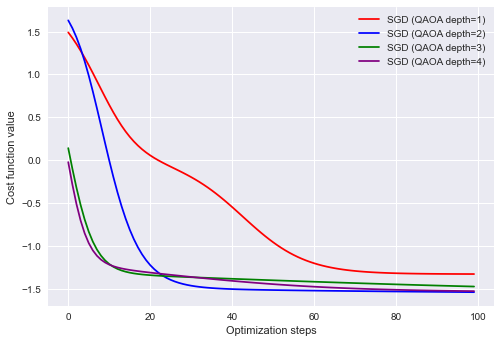

In [235]:
plt.style.use("seaborn")
plt.plot(gd_cost_depth_1, "r", label="SGD (QAOA depth=1)")
plt.plot(gd_cost_depth_2, "b", label="SGD (QAOA depth=2)")
plt.plot(gd_cost_depth_3, "g", label="SGD (QAOA depth=3)")
plt.plot(gd_cost_depth_4, "purple", label="SGD (QAOA depth=4)")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

**Analysis**: For Stochastic Gradient-Descent, depth = 2 reaches the most minimal energy, relative to depth = 1, 3, and 4. Below, we display the probability distribution of the optimal parameter for the QAOA circuit and plot the solution with the highest probability.

In [242]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params_2[0], params_2[1])

In [243]:
occ_index = probs.tolist().index(max(probs))
occupation = '{0:012b}'.format(occ_index)
occ_bools = [bool(int(occ)) for occ in occupation]
occ_bools

[True, True, False, False, True, False, True, True, False, False, False, False]

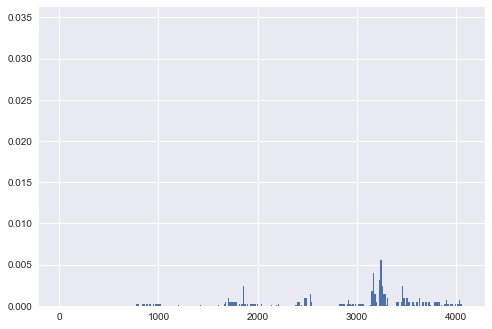

In [244]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

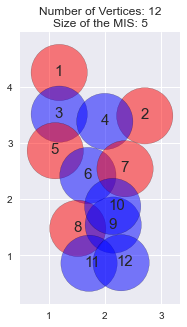

In [245]:
occ_index = probs.tolist().index(max(probs))
occ_string = '{0:012b}'.format(occ_index)
occupation = [bool(int(occ)) for occ in occ_string]
# occupation = udmis.occupations
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111, aspect =1)
for i in range(len(points)):
    x,y = points[i]
    circle = plt.Circle((x,y), 0.5, edgecolor='black', alpha = 0.5,
                        facecolor='r' if occupation[i] else 'b',fill=True)
    ax.add_patch(circle)
    plt.text(x-0.08,y-0.05, i+1, fontsize=15)
plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(points),sum(occupation)))
ax.autoscale()
plt.show()

**Result**: The best performing QAOA depth (depth = 2) for UD-MIS produces sub-optimal results, relative to the results produced by Classical and Quantum Annealing.

**ADAM Optimization**: Lets try a different optimizer, that's performs well in Deep Learning!

In [246]:
steps = 100
init_params = params

In [247]:
adam_cost = []
opt = qml.AdamOptimizer()

theta = init_params
for _ in range(steps):
    theta = opt.step(cost_function, theta)
    adam_cost.append(cost_function(theta))

In [248]:
adam_probs = probability_circuit(theta[0], theta[1])

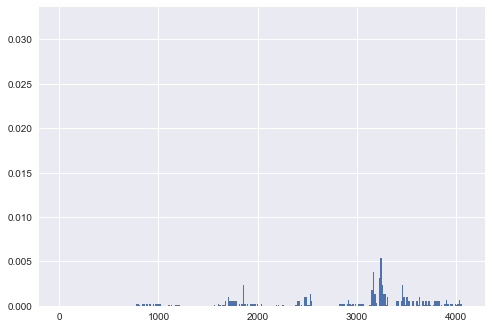

In [249]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), adam_probs)
plt.show()

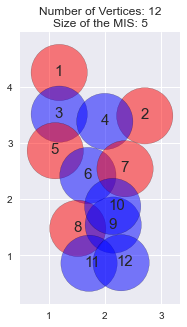

In [250]:
adam_occ_index = adam_probs.tolist().index(max(adam_probs))
adam_occ_string = '{0:012b}'.format(adam_occ_index)
adam_occupation = [bool(int(occ)) for occ in adam_occ_string]
# occupation = udmis.occupations
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111, aspect =1)
for i in range(len(points)):
    x,y = points[i]
    circle = plt.Circle((x,y), 0.5, edgecolor='black', alpha = 0.5,
                        facecolor='r' if adam_occupation[i] else 'b',fill=True)
    ax.add_patch(circle)
    plt.text(x-0.08,y-0.05, i+1, fontsize=15)
plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(points),sum(adam_occupation)))
ax.autoscale()
plt.show()

**Result**: QAOA with ADAM optimization performs sub-optimal as well :(

**SGD vs ADAM**: Does ADAM even improve QAOA's performance? NO!

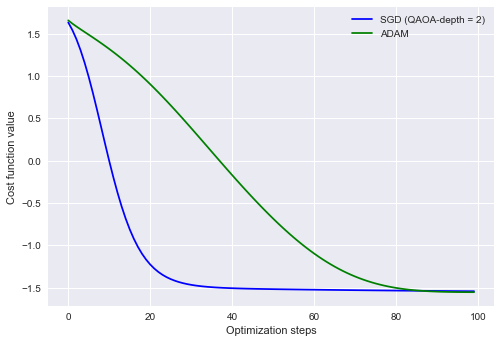

In [251]:
plt.style.use("seaborn")
plt.plot(gd_cost_depth_2, "b", label="SGD (QAOA-depth = 2)")
plt.plot(adam_cost, "g", label="ADAM")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

### Reference

[1] https://en.wikipedia.org/wiki/Adiabatic_quantum_computation <br>
[2] https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula <br>
[3] https://arxiv.org/pdf/quant-ph/0206003.pdf